# XLNet LLM

## Sentiment Analysis using XLNet

### Importing libraries

In [11]:
import os
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLNetTokenizer, XLNetModel

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Reading the csv file

In [12]:
data_file_path = '/kaggle/input/amazon/test.csv'
df_original = pd.read_csv(data_file_path)

## Data Exploration

In [13]:

# Splitting the data into 2
df, df_2 = train_test_split(df_original, test_size=0.5, random_state=42)


### Viewing the number of reviews in the train set

In [14]:
print(len(df))

199999


### Viewing the first 5 entries

In [15]:
df.head()

,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
387723,1,I really tried to like it----,"But my impressions was....yeck. Thin plot, thi..."
153308,1,Please do NOT purchase from this company.,[[ASIN:B0007KQZWU Cuisinart MCP-12 MultiClad P...
379690,1,too theoretical,I bought this thinking it would help me unders...
194003,1,As I Expected...,"If you like clichéd electronic pop, you will l..."
230929,2,Are you a Butterfly?,This is a book i would recommend to all of the...


In [16]:
# Define a function to map sentiment values
def map_values(value):
    if value == 1:
        return "negative"
    elif value == 2:
        return "positive"

new_column_names={'2':'Sentiment number','Great CD':'Description','My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"':'Text Review'}
df.rename(columns=new_column_names, inplace=True)

# Apply the mapping function to create a 'sentiment' column
df['sentiment'] = df['Sentiment number'].apply(map_values)

In [17]:
df['Sentiment number'] = df['Sentiment number'] - 1  # Adjust labels to 0 and 1

### Printing the column names

In [18]:
df.columns

Index(['Sentiment number', 'Description', 'Text Review', 'sentiment'], dtype='object')

In [19]:
# Checking the number of rows and columns
df.shape

(199999, 4)

### Printing the first 5 examples of the updated dataset

In [20]:
df.head()

,Sentiment number,Description,Text Review,sentiment
387723,0,I really tried to like it----,"But my impressions was....yeck. Thin plot, thi...",negative
153308,0,Please do NOT purchase from this company.,[[ASIN:B0007KQZWU Cuisinart MCP-12 MultiClad P...,negative
379690,0,too theoretical,I bought this thinking it would help me unders...,negative
194003,0,As I Expected...,"If you like clichéd electronic pop, you will l...",negative
230929,1,Are you a Butterfly?,This is a book i would recommend to all of the...,positive


In [21]:
print(df['Sentiment number'].value_counts())

Sentiment number
1    100076
0     99923
Name: count, dtype: int64


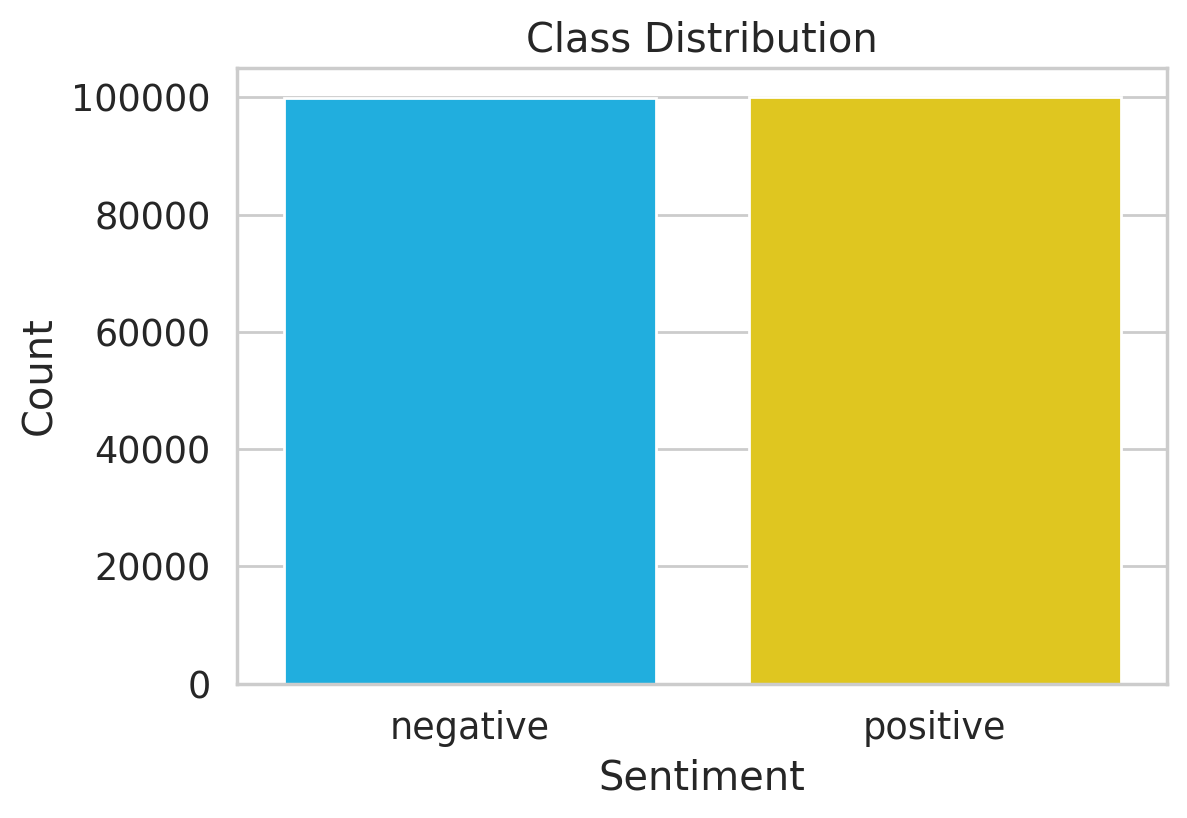

In [22]:
# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'])
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [23]:
print("\nStatistical Summary of Numeric Columns:")
print(df.describe())


Statistical Summary of Numeric Columns:
       Sentiment number
count     199999.000000
mean           0.500383
std            0.500001
min            0.000000
25%            0.000000
50%            1.000000
75%            1.000000
max            1.000000


In [24]:
# Text Data Analysis (Basic)
df['review_length'] = df['Text Review'].apply(len)
print("\nReview Length Descriptive Statistics:")
print(df['review_length'].describe())


Review Length Descriptive Statistics:
count    199999.000000
mean        404.351142
std         233.916343
min          15.000000
25%         207.000000
50%         355.000000
75%         564.000000
max        1009.000000
Name: review_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


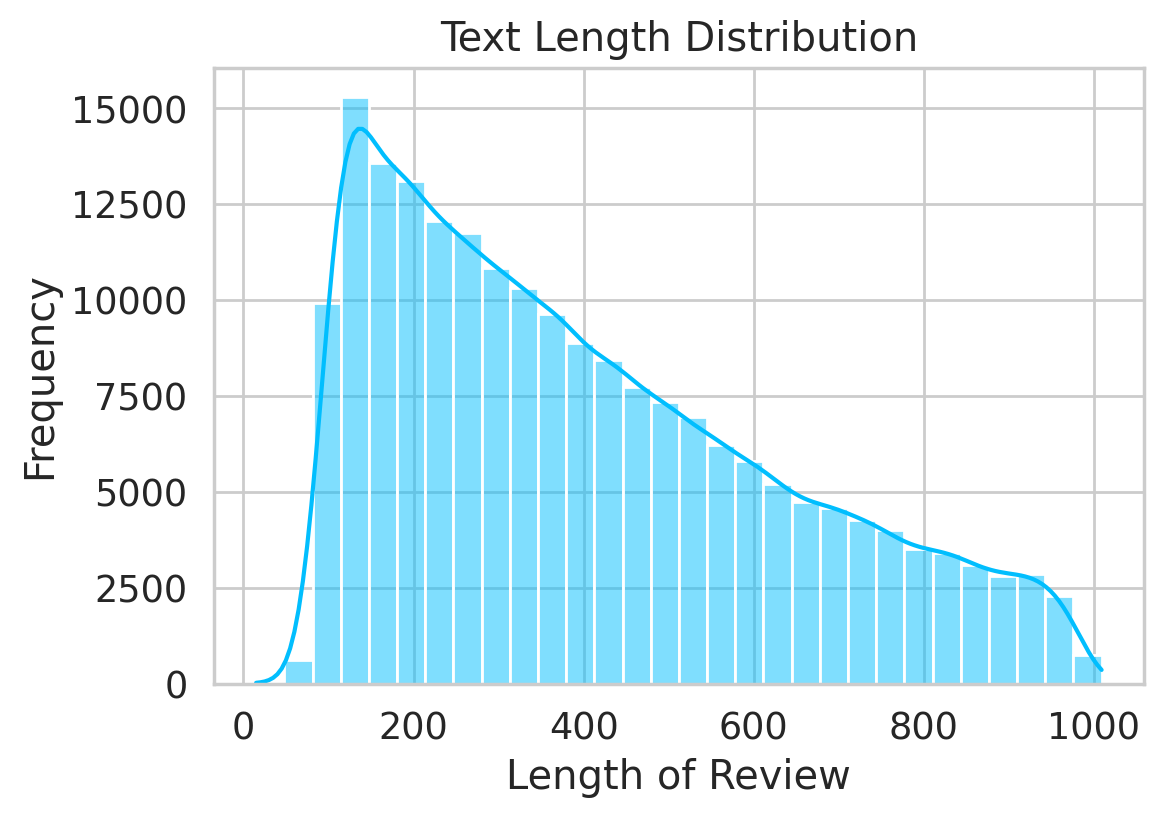

In [25]:
# Text Length Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Review')
plt.ylabel('Frequency')
plt.show()

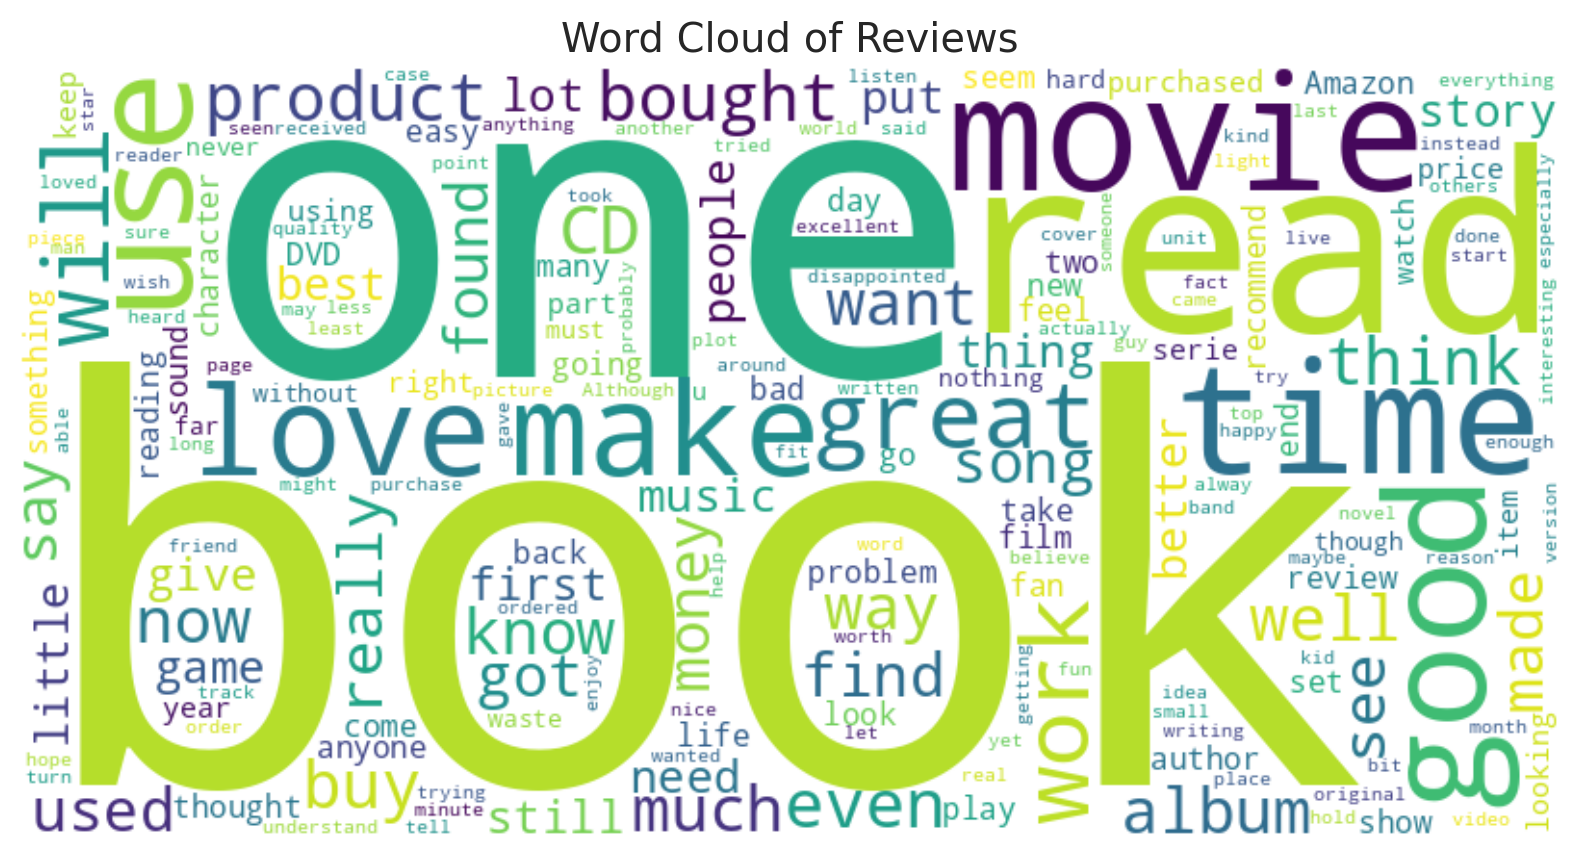

In [26]:
# Word Cloud
from wordcloud import WordCloud

text = " ".join(review for review in df['Text Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

## Data Preprocessing

### Load a pre-trained XLNet Tokenizer

In [27]:
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

In [28]:
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

### Choosing Sequence Length

In [29]:
MAX_LEN = 256

In [30]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

### Data splitting

In [31]:
# Define the split ratios
test_split = 0.15
val_split = 0.15  # 15% of the remaining data after test split

# Split the data into (Train + Validation) and Test
df_train_val, df_test = train_test_split(df, test_size=test_split, random_state=RANDOM_SEED)

# Split the remaining data into Train and Validation
df_train, df_val = train_test_split(df_train_val, test_size=val_split, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape


((144499, 5), (25500, 5), (30000, 5))

## Data Loader

### Creating data loaders. Below is the helper function

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['Text Review'].to_numpy(),
        targets=df['Sentiment number'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
# Example batch from the training data loader

data = next(iter(train_data_loader))
data.keys()


print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Model Initialization

## Sentiment Classification with XLNet and Hugging Face

In [34]:
# Load the model

xlnet_model = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Classifier that uses XLNet model

In [35]:
# Define XLNet model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.xlnet = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[0][:, 0]  # Take the first token ([CLS]) for classification
        output = self.drop(pooled_output)
        return self.out(output)

In [36]:
#Creating an instance and moving to GPU
model = SentimentClassifier(2)
model = model.to(device)

## Evaluation on Pre-trained model before fine-tuning

In [37]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [40]:
print("Evaluating the pre-trained model on the test set before fine-tuning...")
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
print(f'Test Accuracy (Pre-Fine-tuning): {test_acc.item()}')

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

# Classification report and confusion matrix
class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

Evaluating the pre-trained model on the test set before fine-tuning...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Test Accuracy (Pre-Fine-tuning): 0.49696666666666667


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

              precision    recall  f1-score   support

    negative       0.49      0.29      0.36     14948
    positive       0.50      0.71      0.58     15052

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.47     30000
weighted avg       0.50      0.50      0.47     30000



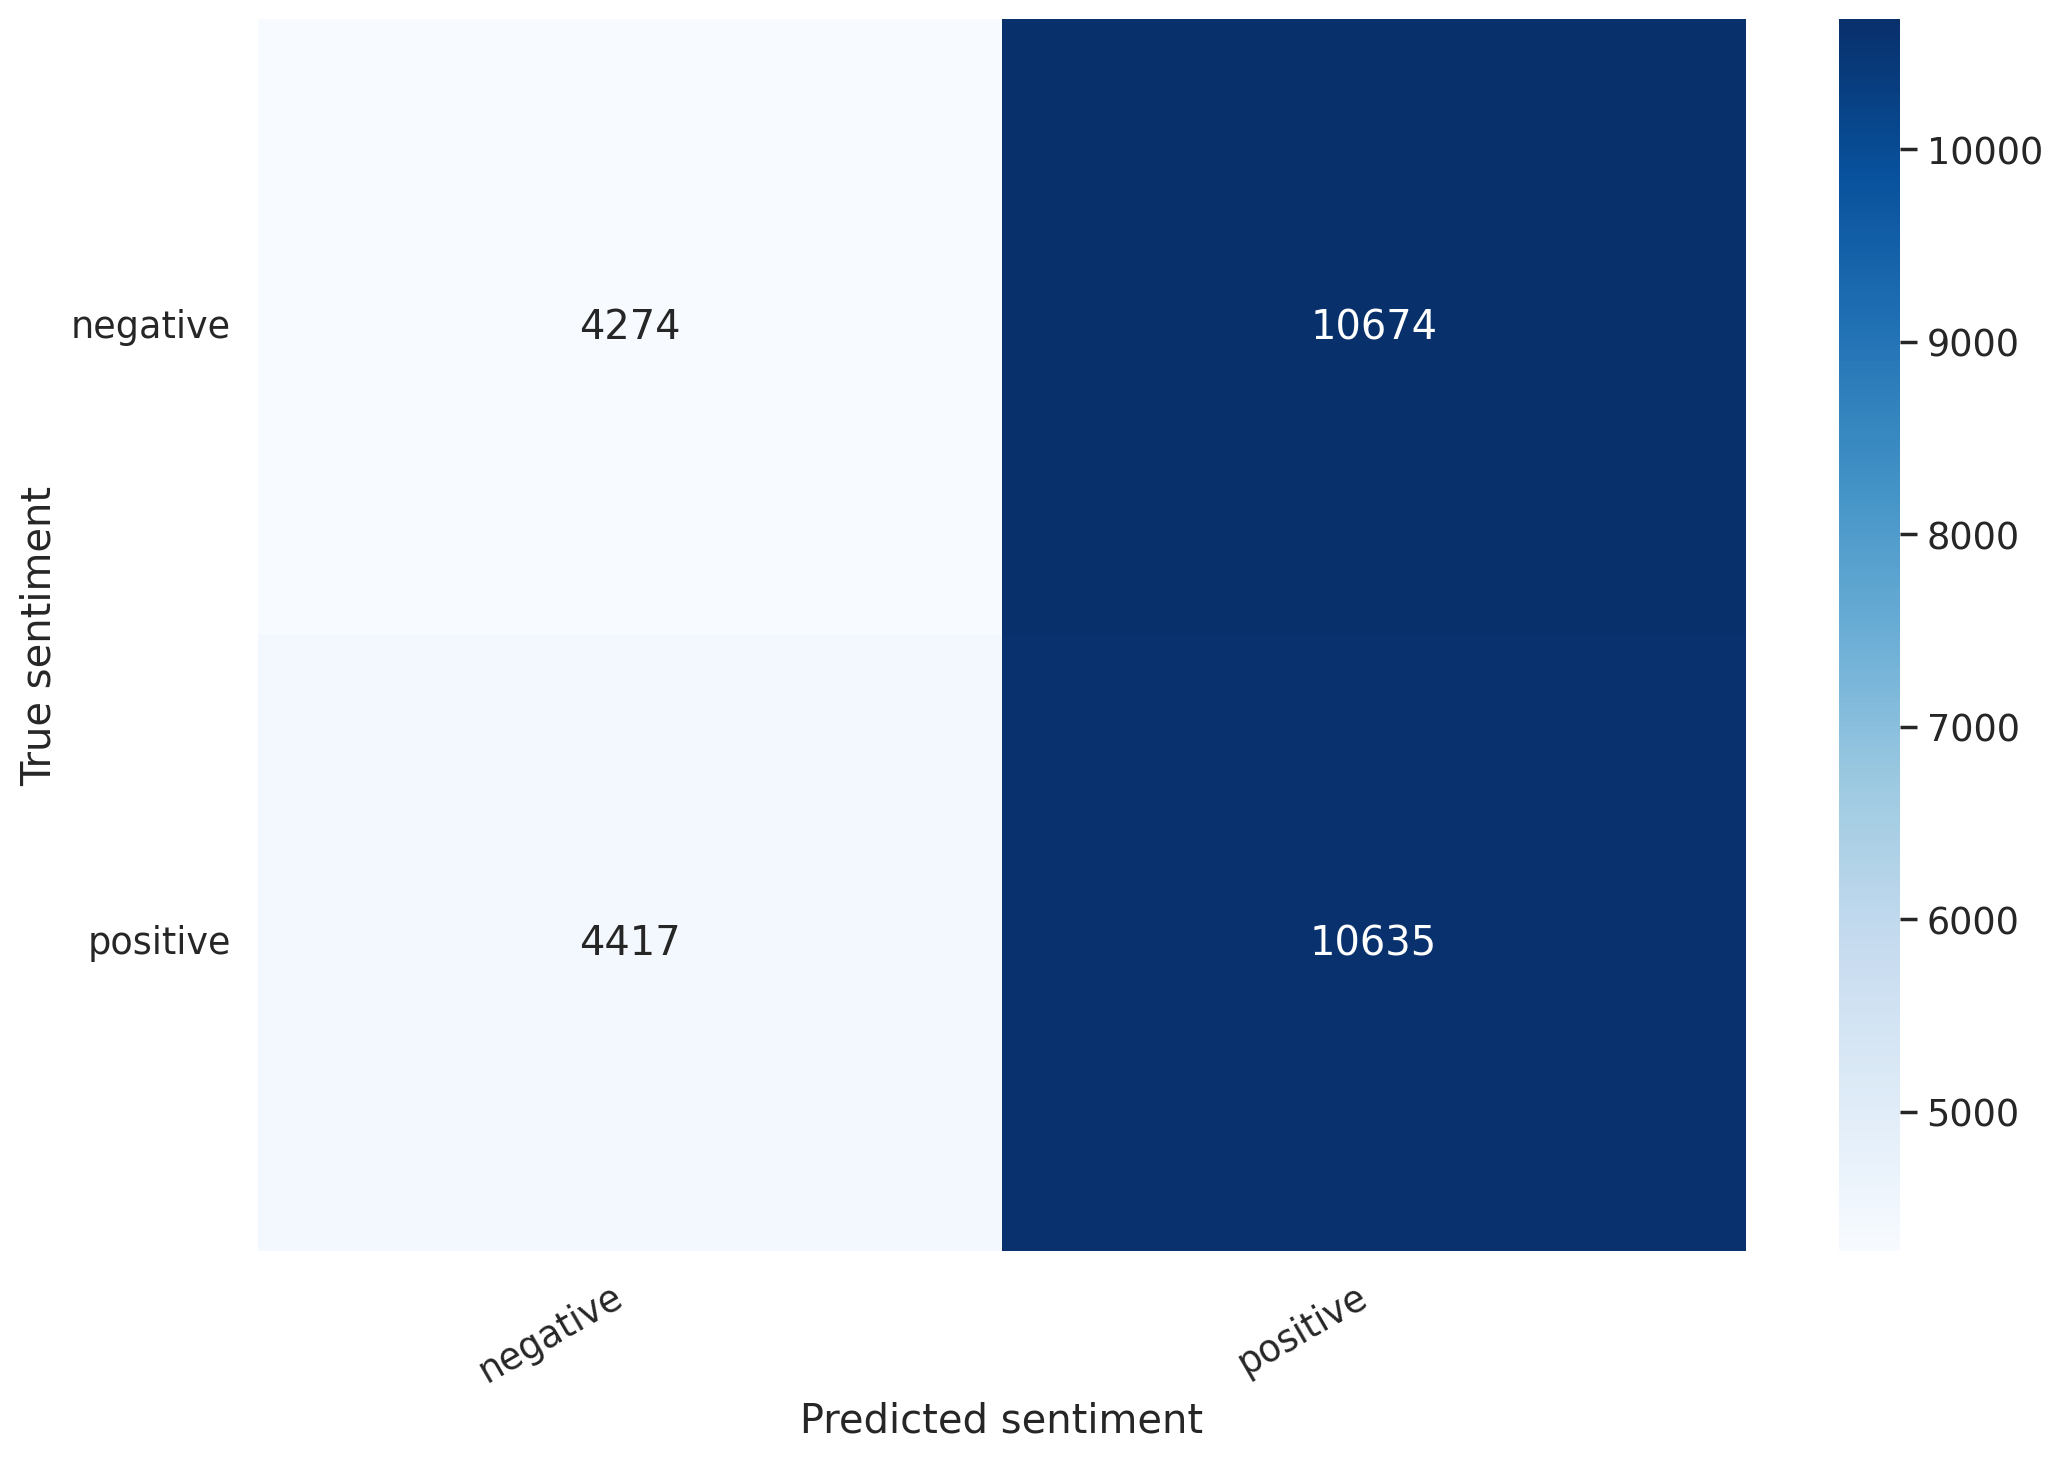

In [41]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [42]:
review_text = "Your services are good. Well done!"

In [43]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1) #Apply softmax to calculate probabilities
_, prediction = torch.max(probabilities, dim=1)
confidence = probabilities[0, prediction.item()].item()
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'Confidence : {confidence * 100:.2f}%')

Review text: Your services are good. Well done!
Sentiment  : negative
Confidence : 69.99%


## Fine-tuning Process

In [45]:
# Move example batch for the training data to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5354, 0.4646],
        [0.2438, 0.7562],
        [0.2738, 0.7262],
        [0.5954, 0.4046],
        [0.4454, 0.5546],
        [0.6133, 0.3867],
        [0.2755, 0.7245],
        [0.5510, 0.4490],
        [0.3357, 0.6643],
        [0.6322, 0.3678],
        [0.4962, 0.5038],
        [0.5036, 0.4964],
        [0.2528, 0.7472],
        [0.6753, 0.3247],
        [0.3235, 0.6765],
        [0.3251, 0.6749]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

### Freeze all layers; finetune classification layer

In [47]:
# Freeze all the parameters in XLNet
for param in model.xlnet.parameters():
    param.requires_grad = False

# Only the parameters in the classification layer will be fine-tuned
optimizer = AdamW(model.out.parameters(), lr=3e-5, correct_bias=False)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [48]:
EPOCHS = 3
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

### Helper function for training our model for one epoch

In [49]:
#pip install tqdm

In [50]:
from tqdm import tqdm

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader, desc='Training', leave=False):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

### Training loop

In [51]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.6779594661732286 accuracy 0.6071045474363145


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5477490436140836 accuracy 0.7468627450980392

Epoch 2/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.6185962804275555 accuracy 0.6605651250181662


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5333517296438385 accuracy 0.7614509803921569

Epoch 3/3
----------


Training:   0%|          | 0/9032 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.6117108347400878 accuracy 0.6657831542086797


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val   loss 0.5363174704753021 accuracy 0.7505098039215686

CPU times: user 2h 20min, sys: 34.6 s, total: 2h 20min 35s
Wall time: 2h 11min 8s


### Plotting the training and validation accuracy

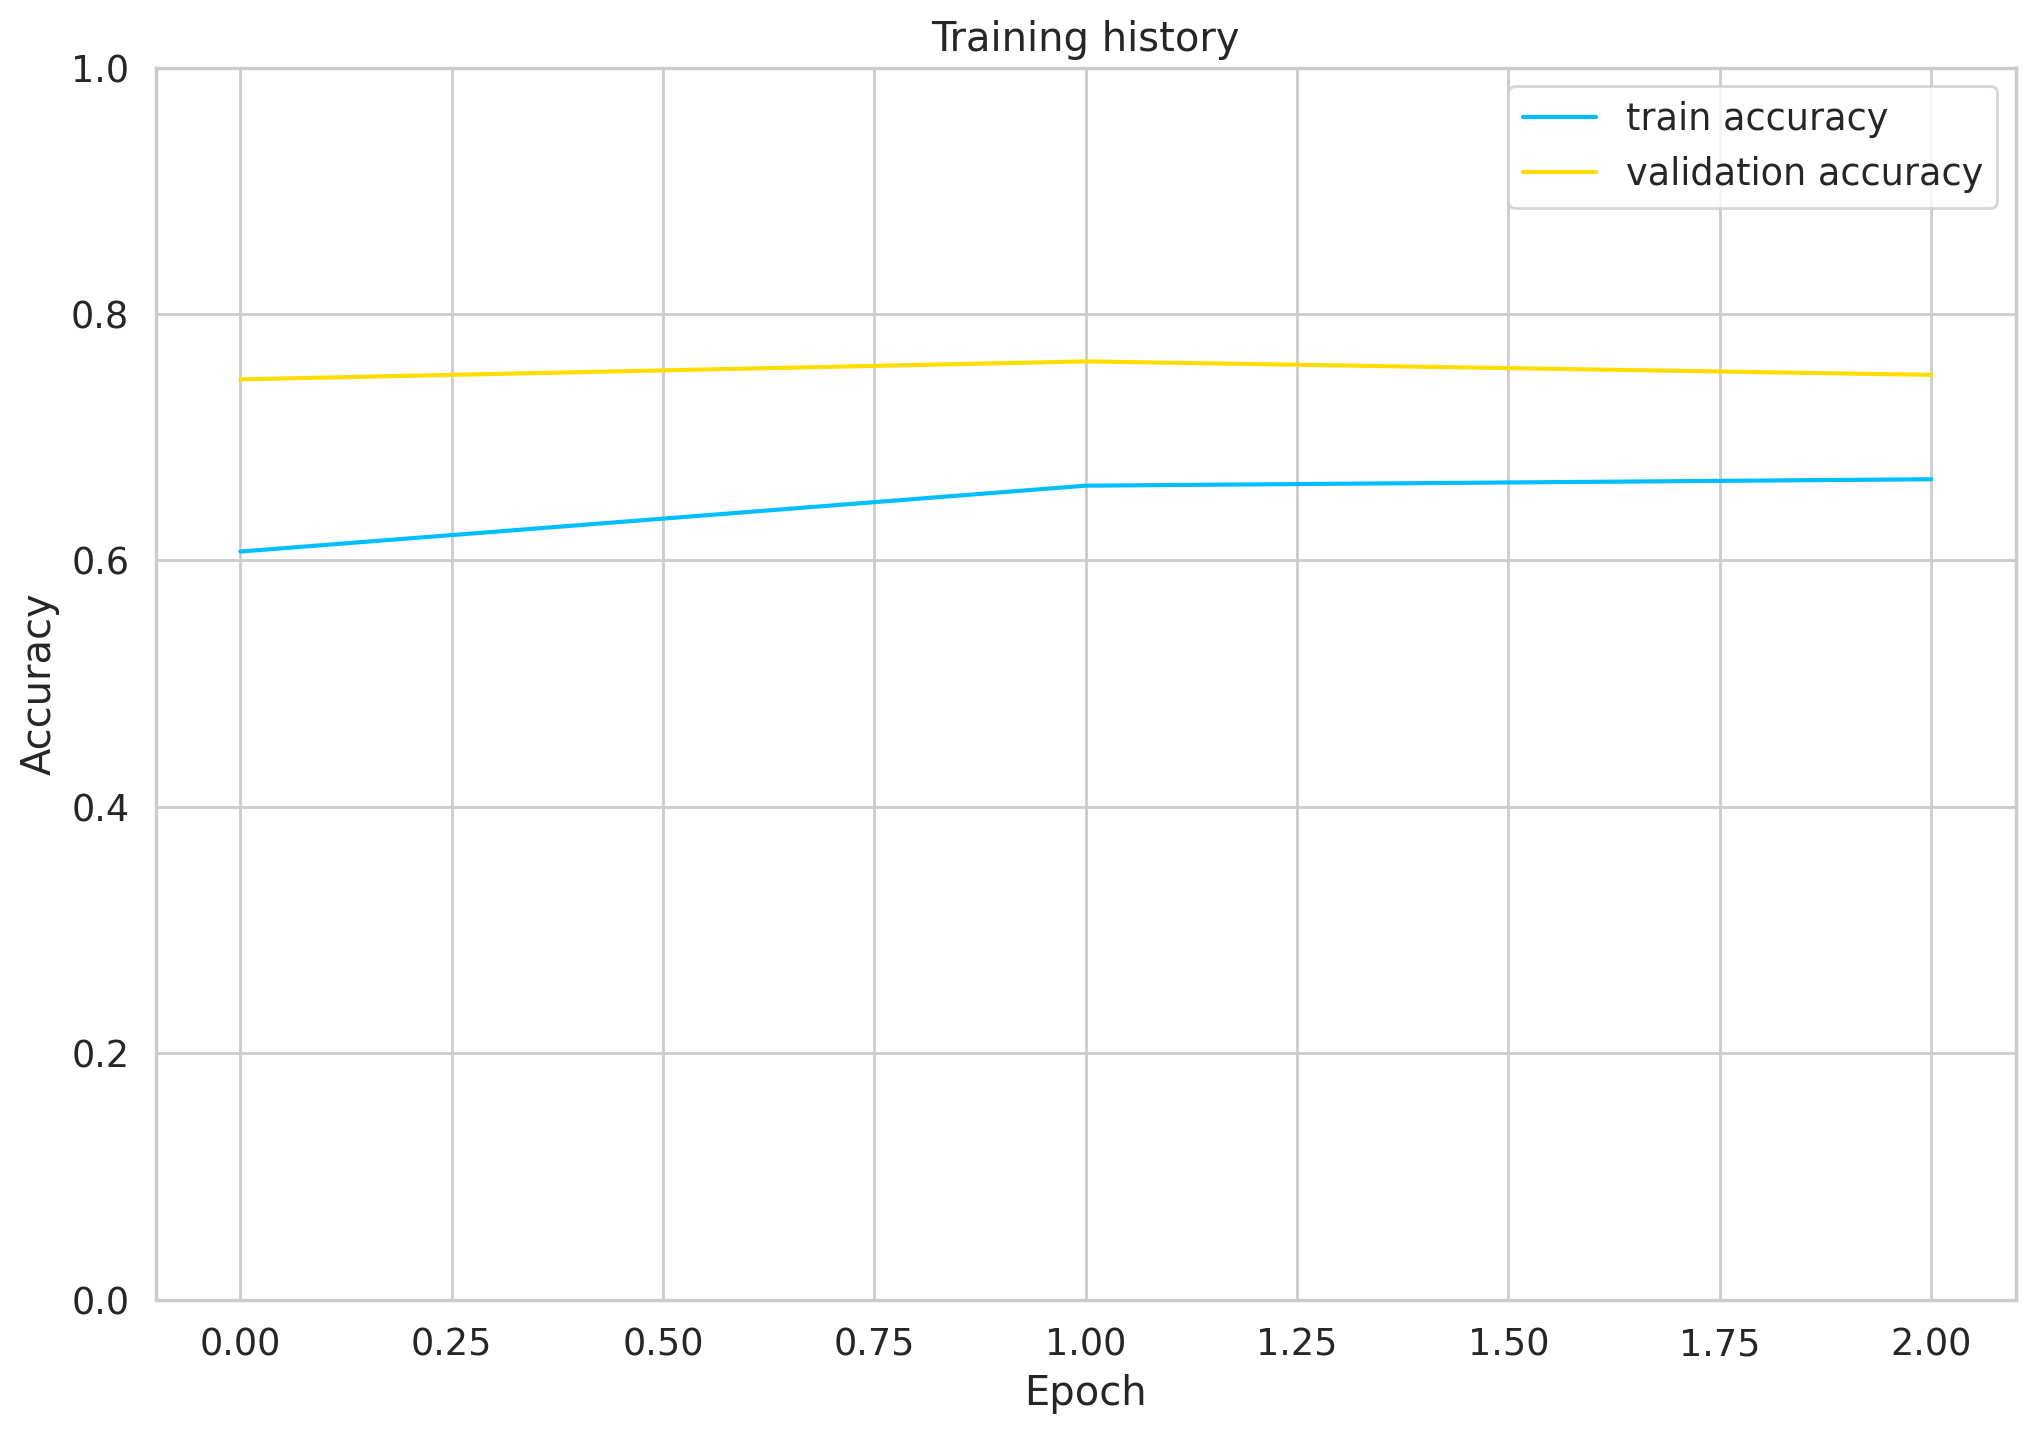

In [52]:
# Convert each value in the lists to CPU-based if they are CUDA tensors
train_acc = [x.cpu().item() if torch.is_tensor(x) and x.is_cuda else x for x in history['train_acc']]
val_acc = [x.cpu().item() if torch.is_tensor(x) and x.is_cuda else x for x in history['val_acc']]

# Now plot
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()




## Evaluation of finetuned model

In [53]:
# Save the model state
model_save_path = 'sentiment_classifier_model.pth'
torch.save(model.state_dict(), model_save_path)


In [54]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Test Accuracy (Post-Fine-tuning): {test_acc.item()}')
#test_acc.item()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Test Accuracy (Post-Fine-tuning): 0.7480333333333333


In [55]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

### Classification report

In [56]:
class_names = ['negative', 'positive']

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.69      0.89      0.78     14948
    positive       0.84      0.61      0.71     15052

    accuracy                           0.75     30000
   macro avg       0.77      0.75      0.74     30000
weighted avg       0.77      0.75      0.74     30000



### Confusion matrix

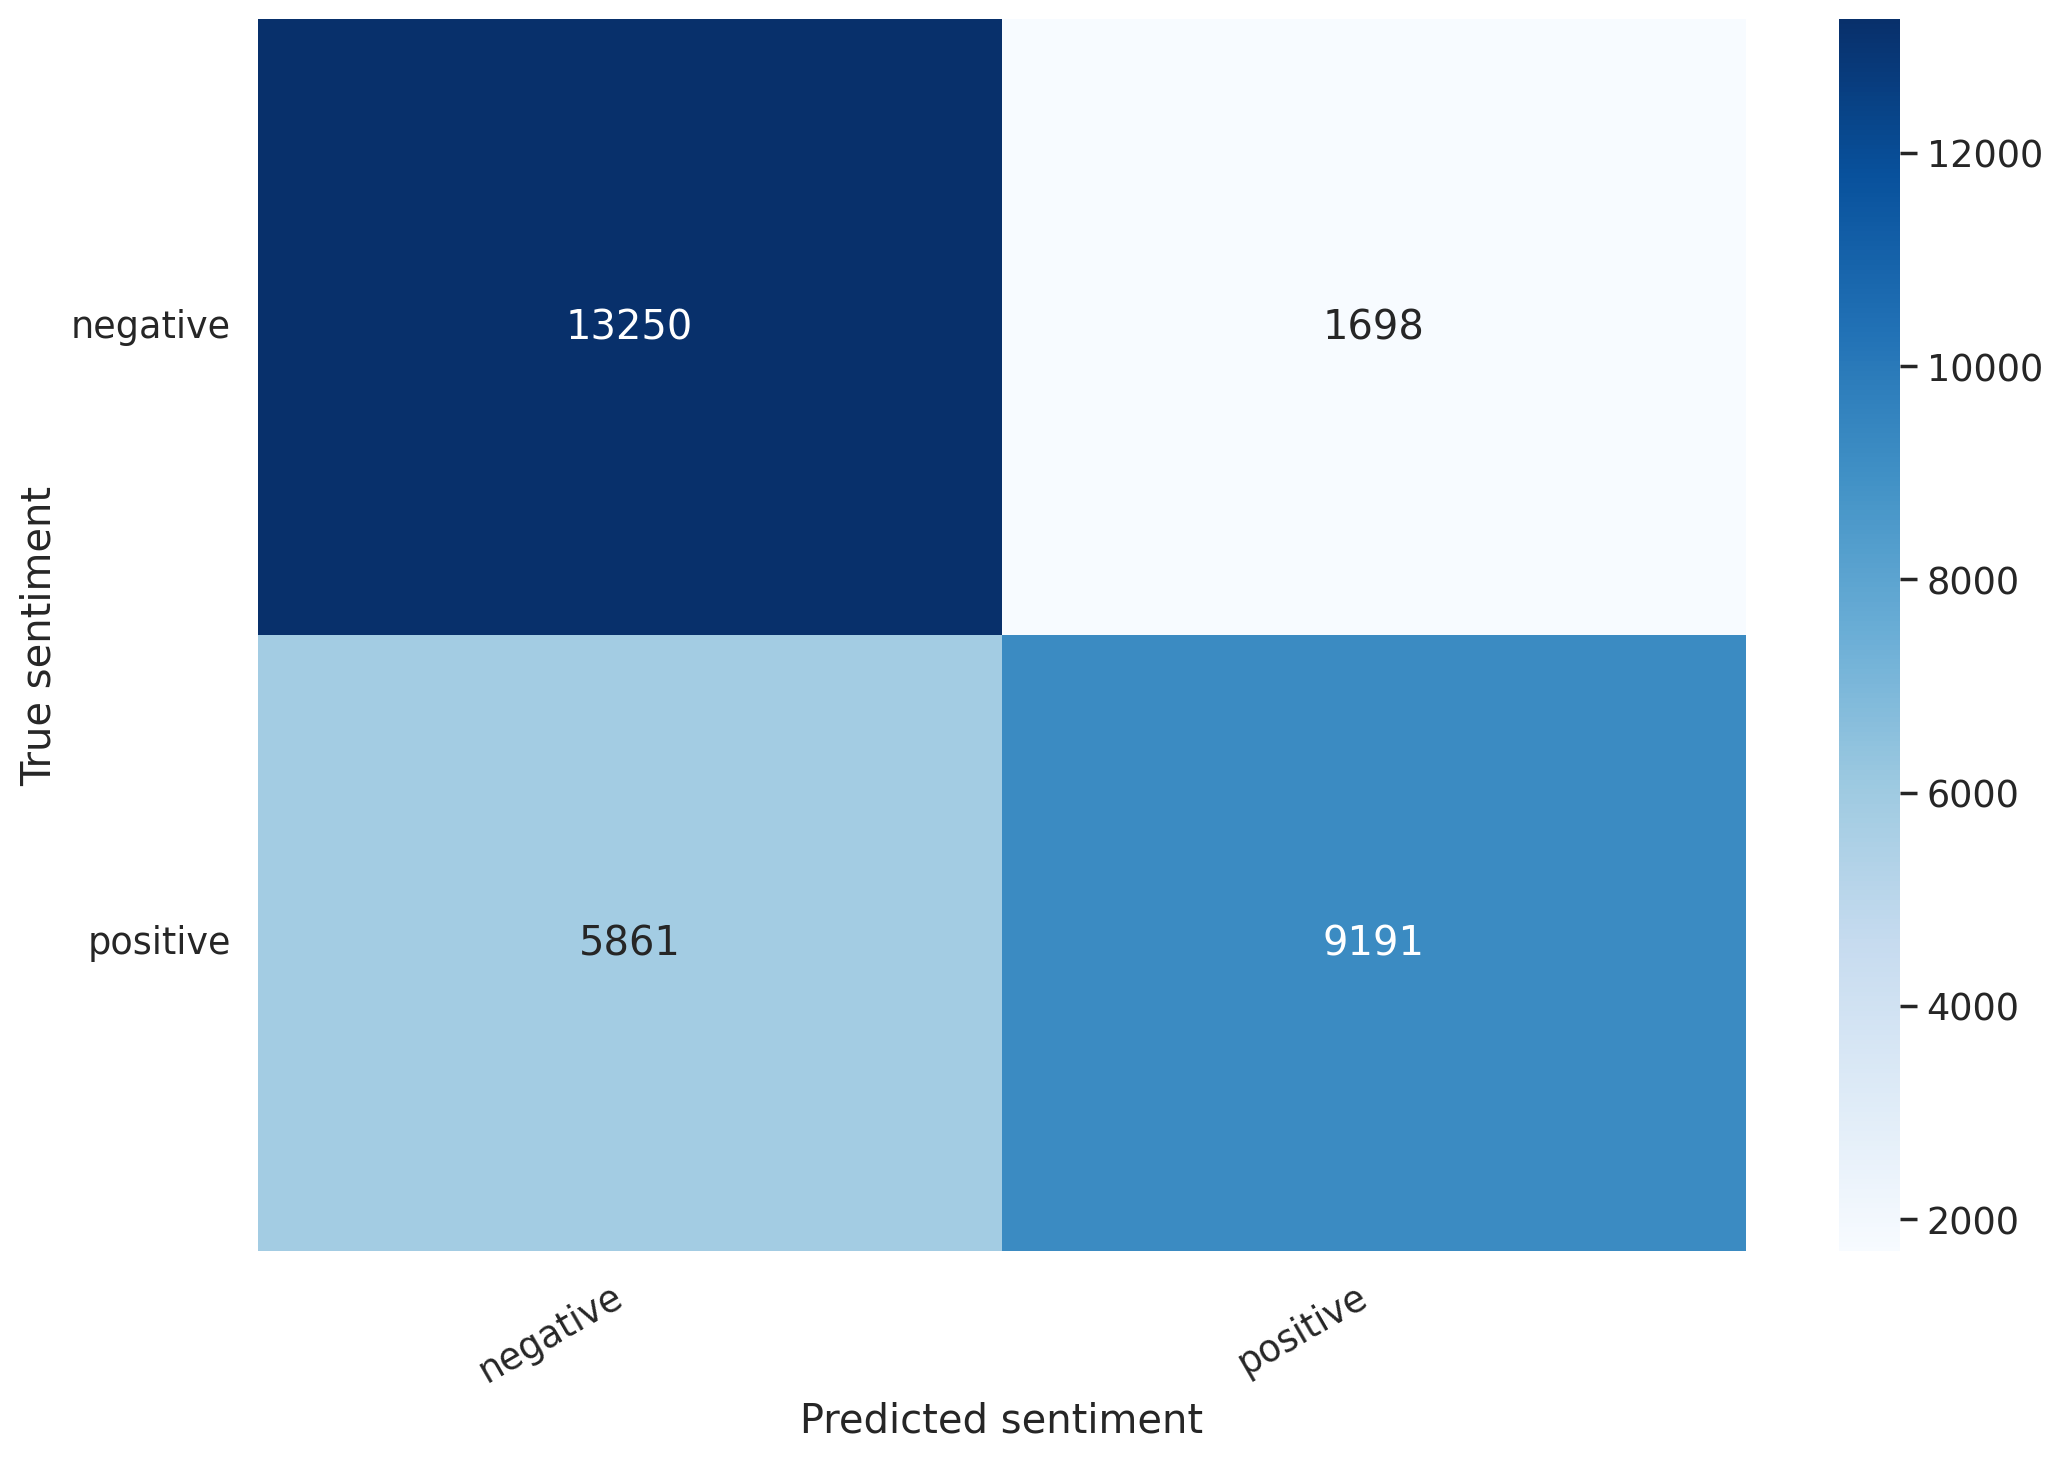

In [57]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predicting on Raw Text

In [58]:
review_text = "I got my fries very late from your shop. I am very sad. You should improve your services."

### Tokenize to encode the text

In [59]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Get predictions from the model

In [60]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1) #Apply softmax to calculate probabilities
_, prediction = torch.max(probabilities, dim=1)
confidence = probabilities[0, prediction.item()].item()
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')
print(f'Confidence : {confidence * 100:.2f}%')

Review text: I got my fries very late from your shop. I am very sad. You should improve your services.
Sentiment  : positive
Confidence : 68.40%
